In [2]:
# %pip install pandas
# %pip install numpy
# %pip install glob
# %pip install matplotlib

import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt

# Take raw pbp data from NCAA and add game state representations.

# Also note the counts, WP, and transition probabilities for each game state.

In [ ]:
inning_values = np.arange(1, 10)
top_values = [0, 1]
outs_values = np.arange(0, 3)
base_code_values = np.arange(0, 9)
score_diff_values = np.arange(-10, 11)

# Create all combinations of game states
all_game_states = pd.DataFrame(np.array(np.meshgrid(
    inning_values, 
    top_values, 
    outs_values, 
    base_code_values, 
    score_diff_values
    )).T.reshape(-1, 5), 
    columns=['Inning', 'Top', 'Outs', 'BaseCode', 'ScoreDiff'])


# I: Inning
# T: Top (0) or Bottom (1)
# O: Outs
# B: BaseCode
# S: ScoreDiff
def create_game_states(innings, tops, outs, base_codes, score_diffs):
    game_states = []
    for i in range(len(innings)):
        game_states.append(f'{innings[i]}_{tops[i]}_{outs[i]}_{base_codes[i]}_{score_diffs[i]}')
    return game_states

all_game_states.index = create_game_states(
    all_game_states['Inning'], 
    all_game_states['Top'], 
    all_game_states['Outs'], 
    all_game_states['BaseCode'], 
    all_game_states['ScoreDiff']
    )

game_state_totals = pd.DataFrame(0, index=all_game_states.index, columns=['N', 'Wins'])
all_game_states = all_game_states.drop(['Inning', 'Top', 'Outs', 'BaseCode', 'ScoreDiff'], axis=1)
state_transition_matrix = pd.DataFrame(0, index=all_game_states.index, columns=all_game_states.index)

# read all csvs in ../R/data/pbps directory or subdirectories
csv_files = glob.glob('../R/data/raw-pbps/*/*.csv', recursive=True)
n = len(csv_files)
for i, file in enumerate(csv_files):
    # Print checkpoints at every 5000 files
    # if (i % 5000 == 0):
    #     print(f'{i}/{n}')
    print(f'{i}/{n}')

    pbp_df = pd.read_csv(file, index_col=None, header=0)
    if (pbp_df.shape[0] == 0 or 'top_inning' not in pbp_df.columns):
        print('Data Error')
        continue

    pbp_df['game_state'] = create_game_states(
        pbp_df['inning'], 
        pbp_df['top_inning'], 
        pbp_df['outs_before'], 
        pbp_df['base_cd_before'], 
        np.maximum(np.minimum(pbp_df['home_score_before'] - pbp_df['away_score_before'], 10), -10)
        )
    
    pbp_df['next_game_state'] = pbp_df['game_state'].shift(-1)
    # pbp_df.to_csv('./data/pbp-with-pitchers-with-game-states/' + file.split('/')[-1], index=False)

    game_state_totals.loc[pbp_df['game_state'], 'N'] += 1
    if (pbp_df['won'].all()):
        game_state_totals.loc[pbp_df['game_state'], 'Wins'] += 1

    for index, row in pbp_df.iterrows():
        if row['next_game_state'] in state_transition_matrix.index:
            state_transition_matrix.loc[row['game_state'], row['next_game_state']] += 1

game_state_totals = game_state_totals.loc[game_state_totals['N'] > 0]
game_state_totals['WP'] = game_state_totals['Wins'] / game_state_totals['N']

n_game_states_observed = game_state_totals['N'].sum()
game_state_totals['freq'] = game_state_totals['N'] / n_game_states_observed

game_state_totals.to_csv('./data/game-state-totals.csv')

def calculate_transition_probabilities(row):
    row_sum = row.sum()
    return row / row_sum if row_sum != 0 else row

transition_probability_matrix = state_transition_matrix.apply(calculate_transition_probabilities, axis=1)
transition_probability_matrix.to_csv('./data/transition-probability-matrix.csv')

# Calculate expected delta win probability from each game state.

# Calculate average expected delta win probability for all game states.

In [ ]:
transition_probability_matrix = transition_probability_matrix.loc[game_state_totals.index, game_state_totals.index]

print(f'Number of game states: {len(game_state_totals)}')
print(f'Shape of transition probability matrix: {transition_probability_matrix.shape}')

expected_game_state_delta_wpa = pd.DataFrame(index=game_state_totals.index)

# Each key is an column (next_state) of transition_probability_matrix
# Each value is a list of start_state (indices) in transition_probability_matrix that have a transition probability to the key
weighted_delta_wpa_cols = {}
for i, col in enumerate(transition_probability_matrix.columns):
    print(f'Progress: {i+1}/{len(transition_probability_matrix.columns)}')

    next_state_wp = game_state_totals.loc[col, 'WP']
    weighted_delta_wpa_cols[col] = transition_probability_matrix[col] * np.square(next_state_wp - game_state_totals['WP'])

weighted_game_state_delta_wpa = pd.concat(weighted_delta_wpa_cols.values(), axis=1)

expected_game_state_delta_wpa['expected_delta_wpa'] = np.sqrt(weighted_game_state_delta_wpa.sum(axis=1))
expected_game_state_delta_wpa = expected_game_state_delta_wpa[['expected_delta_wpa']]

average_delta_wpa = np.sum(expected_game_state_delta_wpa['expected_delta_wpa'] * game_state_totals['freq']) 
print(f'Average "game-state-agnostic" delta WPA {average_delta_wpa}')

expected_game_state_delta_wpa['LI'] = expected_game_state_delta_wpa['expected_delta_wpa'] / average_delta_wpa
pd.concat([expected_game_state_delta_wpa, game_state_totals['freq']], axis = 1).to_csv('./data/expected-game-state-delta-wpa.csv')

print(f'Number of rows with 0 expected delta wpa: {len(expected_game_state_delta_wpa.loc[expected_game_state_delta_wpa["expected_delta_wpa"] == 0])}')

# Make a histogram of expected_delta_wpa values

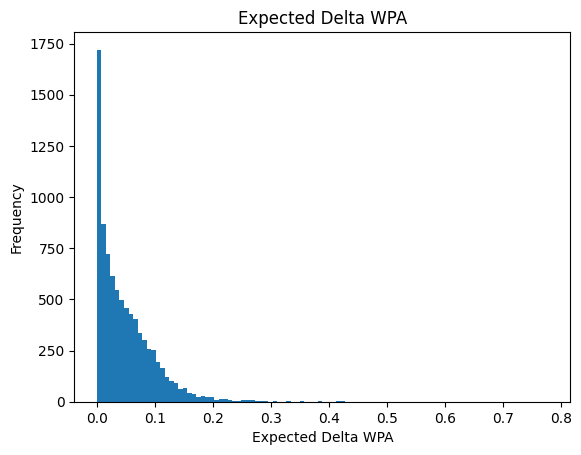

In [28]:
plt.hist(expected_game_state_delta_wpa['expected_delta_wpa'], bins=100)
plt.title('Expected Delta WPA')
plt.xlabel('Expected Delta WPA')
plt.ylabel('Frequency')
plt.show()


In [24]:
n = len(pbps)

long_pbp_df = pd.concat(pbps)
long_pbp_df['WPA'] = long_pbp_df.apply(lambda row: game_state_totals.loc[row['next_game_state'], 'WP'] - game_state_totals.loc[row['game_state'], 'WP'], axis=1)
long_pbp_df['LI'] = long_pbp_df.apply(lambda row: expected_game_state_delta_wpa.loc[row['game_state'], 'LI'], axis=1)
long_pbp_df['WPA / LI'] = long_pbp_df['WPA'] / pbp_df['LI']

KeyboardInterrupt: 

In [ ]:
for inning in game_state_totals['Inning'].unique():
    for top in [1, 0]:
        game_state_totals.loc[(game_state_totals['Top'] == top) & (game_state_totals['Inning'] == inning)].groupby(['ScoreDiff'])['WP'].mean().plot.bar()
        plt.title(f'{"Top" if top == 1 else "Bottom"} Inning {inning}')
        plt.xlabel('Score Difference')
        plt.ylabel('Win Probability')
        plt.ylim(0, 1)
        plt.savefig(f'./plots/{"Top" if top == 1 else "Bottom"}_inning_{inning}_score_diff.png')
        plt.show()

for inning in game_state_totals['Inning'].unique():
    for top in [1, 0]:
        game_state_totals.loc[(game_state_totals['Top'] == top) & (game_state_totals['Inning'] == inning)].groupby(['Outs'])['WP'].mean().plot.bar()
        plt.title(f'{"Top" if top == 1 else "Bottom"} Inning {inning}')
        plt.xlabel('Outs')
        plt.ylabel('Win Probability')
        plt.ylim(0, 1)
        plt.savefig(f'./plots/{"Top" if top == 1 else "Bottom"}_inning_{inning}_outs.png')
        plt.show()